In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "True"
import tensorflow as tf
print("TensorFlow versión:", tf.__version__)
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))


TensorFlow versión: 2.10.1
GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, Embedding, Reshape, Flatten, Dropout, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LayerNormalization, Add, Multiply,GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

## Cargar datasets

In [3]:
df = pd.read_csv("Data_completa_enrriquecida.csv")  
df_audio_1 = pd.read_csv("features_extracted.csv")
df_audio_2 = pd.read_csv("features_extracted_original.csv")
df_audio_3 = pd.read_csv("features_extracted_final.csv")
df_audio_4 = pd.read_csv("features_extracted_final_second.csv")
df_audio_5 = pd.read_csv("features_extracted_final_third.csv")
df_audio_6 = pd.read_csv("features_extracted_lastTrue.csv")
df_audio_7 = pd.read_csv("features_extracted_lastTrue2.csv")
df_audio_8 = pd.read_csv("features_extracted_newQ4.csv")
df_audio_features = pd.concat([df_audio_1,df_audio_2,df_audio_3,df_audio_4,df_audio_5,df_audio_6,df_audio_7,df_audio_8],ignore_index = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24966 entries, 0 to 24965
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Letra                   24966 non-null  object 
 1   Idioma                  24848 non-null  object 
 2   lyrics_state            24966 non-null  object 
 3   hasLetra                24966 non-null  float64
 4   Lyrics                  24966 non-null  object 
 5   Lyrics_proces           24966 non-null  object 
 6   songId                  24966 non-null  object 
 7   track_uri               24966 non-null  object 
 8   track_name              24966 non-null  object 
 9   artist_uri              24966 non-null  object 
 10  artist_info             24966 non-null  object 
 11  artist_name             24966 non-null  object 
 12  artist_pop              24966 non-null  float64
 13  album                   24964 non-null  object 
 14  track_pop               24966 non-null

## Ver duplicados datasets

In [5]:
print("Número de songIds únicos en df:", df['songId'].nunique())
print("Número de songIds únicos en df_audio_features:", df_audio_features['song_id'].nunique())

Número de songIds únicos en df: 24026
Número de songIds únicos en df_audio_features: 5043


In [6]:

song_id_counts = df['songId'].value_counts()

duplicated_song_ids = song_id_counts[song_id_counts > 1].index

df[df['songId'].isin(duplicated_song_ids)].head(10)


,Letra,Idioma,lyrics_state,hasLetra,Lyrics,Lyrics_proces,songId,track_uri,track_name,artist_uri,...,dominance_tags,mbid,spotify_id,genre,cuadrante,cuadReal,lexicones,emociones,emocionesLetra,emocion_mas_comun
28,Data/Letras/45-Hush-Hush;-Hush-Hush-The-Pussyc...,en,complete,1.0,Hush Hush; Hush Hush Lyrics[Intro: Nicole Sche...,oohoohooh ohoh yeah oohooh needed strong neede...,hush-hush;-hush-hush-pussycat-dolls.txt,spotify:track:2H9CKpZiLDF223BbwehpDF,Hush Hush; Hush Hush - Main,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,...,6.241222,ec352164-18e9-4b52-881d-99442b9f9f41,2H9CKpZiLDF223BbwehpDF,pop,3,1,[0. 3. 0. 0. 0. 3. 2. 0. 0. 0.],"['anticipation', 'negative', 'positive']","['3', '2', '1']",3
29,Data/Letras/45-Hush-Hush;-Hush-Hush-The-Pussyc...,en,complete,1.0,Hush Hush; Hush Hush Lyrics[Intro: Nicole Sche...,oohoohooh ohoh yeah oohooh needed strong neede...,hush-hush;-hush-hush-pussycat-dolls.txt,spotify:track:2H9CKpZiLDF223BbwehpDF,Hush Hush; Hush Hush - Main,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,...,4.708958,d86b4684-5222-44d9-91de-62fd397e524e,2H9CKpZiLDF223BbwehpDF,pop,0,1,[0. 3. 0. 0. 0. 3. 2. 0. 0. 0.],"['anticipation', 'negative', 'positive']","['3', '2', '1']",3
30,Data/Letras/45-Hush-Hush;-Hush-Hush-The-Pussyc...,en,complete,1.0,Hush Hush; Hush Hush Lyrics[Intro: Nicole Sche...,oohoohooh ohoh yeah oohooh needed strong neede...,hush-hush;-hush-hush-pussycat-dolls.txt,spotify:track:2H9CKpZiLDF223BbwehpDF,Hush Hush; Hush Hush - Main,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,...,6.241222,ec352164-18e9-4b52-881d-99442b9f9f41,2H9CKpZiLDF223BbwehpDF,pop,3,1,[0. 3. 0. 0. 0. 3. 2. 0. 0. 0.],"['anticipation', 'negative', 'positive']","['3', '2', '1']",3
31,Data/Letras/45-Hush-Hush;-Hush-Hush-The-Pussyc...,en,complete,1.0,Hush Hush; Hush Hush Lyrics[Intro: Nicole Sche...,oohoohooh ohoh yeah oohooh needed strong neede...,hush-hush;-hush-hush-pussycat-dolls.txt,spotify:track:2H9CKpZiLDF223BbwehpDF,Hush Hush; Hush Hush - Main,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,...,4.708958,d86b4684-5222-44d9-91de-62fd397e524e,2H9CKpZiLDF223BbwehpDF,pop,0,1,[0. 3. 0. 0. 0. 3. 2. 0. 0. 0.],"['anticipation', 'negative', 'positive']","['3', '2', '1']",3
205,Data/Letras/360-A-Better-Son-Daughter-Rilo-Kil...,en,complete,1.0,A Better Son/Daughter Lyrics[Verse 1]\nSometim...,morning petrified awake open eyes weight crush...,a-better-son-daughter-rilo-kiley.txt,spotify:track:71sC9gVXaFRwAMHJyQO8al,A Better Son/Daughter,spotify:artist:2cevwbv7ISD92VMNLYLHZA,...,5.017783,f2e8cdfe-2b1e-4cc4-810e-2b675f438039,71sC9gVXaFRwAMHJyQO8al,indie,3,3,[0. 0. 0. 0. 0. 0. 2. 0. 0. 2.],"['positive', 'trust']","['1', '3']",1
206,Data/Letras/360-A-Better-Son-Daughter-Rilo-Kil...,en,complete,1.0,A Better Son/Daughter Lyrics[Verse 1]\nSometim...,morning petrified awake open eyes weight crush...,a-better-son-daughter-rilo-kiley.txt,spotify:track:71sC9gVXaFRwAMHJyQO8al,A Better Son/Daughter,spotify:artist:2cevwbv7ISD92VMNLYLHZA,...,5.345153,NaN,71sC9gVXaFRwAMHJyQO8al,indie,0,3,[0. 0. 0. 0. 0. 0. 2. 0. 0. 2.],"['positive', 'trust']","['1', '3']",1
207,Data/Letras/360-A-Better-Son-Daughter-Rilo-Kil...,en,complete,1.0,A Better Son/Daughter Lyrics[Verse 1]\nSometim...,morning petrified awake open eyes weight crush...,a-better-son-daughter-rilo-kiley.txt,spotify:track:71sC9gVXaFRwAMHJyQO8al,A Better Son/Daughter,spotify:artist:2cevwbv7ISD92VMNLYLHZA,...,5.017783,f2e8cdfe-2b1e-4cc4-810e-2b675f438039,71sC9gVXaFRwAMHJyQO8al,indie,3,3,[0. 0. 0. 0. 0. 0. 2. 0. 0. 2.],"['positive', 'trust']","['1', '3']",1
208,Data/Letras/360-A-Better-Son-Daughter-Rilo-Kil...,en,complete,1.0,A Better Son/Daughter Lyrics[Verse 1]\nSometim...,morning petrified awake open eyes weight crush...,a-better-son-daughter-rilo-kiley.txt,spotify:track:71sC9gVXaFRwAMHJyQO8al,A Better Son/Daughter,spotify:artist:2cevwbv7ISD92VMNLYLHZA,...,5.345153,NaN,71sC9gVXaFRwAMHJyQO8al,indie,0,3,[0. 0. 0. 0. 0. 0. 2. 0. 0. 2.],"['positive', 'trust']","['1', '3']",1
209,Data/Letras/9612-A-Better-Son-Daughter-Rilo-Ki...,en,complete,1.0,A B

## Revisar correlación entre variables

In [7]:
numeric_cols = ["number_of_emotion_tags", "danceability", "tempo", "loudness","key","mode","speechiness","acousticness","instrumentalness",
"liveness",'track_pop']


In [8]:
df["cuadReal"] = df["cuadReal"].astype(float)

# 1) Forma rápida: corrwith
df[numeric_cols].corrwith(df["cuadReal"], method='pearson')

number_of_emotion_tags    0.121623
danceability             -0.190604
tempo                    -0.128196
loudness                 -0.539592
key                      -0.021767
mode                      0.019545
speechiness              -0.112132
acousticness              0.532396
instrumentalness          0.126231
liveness                 -0.127395
track_pop                -0.064800
dtype: float64

In [9]:
numeric_cols = [
    'danceability', 'loudness', 'acousticness'
]

In [10]:
X_num = df[numeric_cols].values

In [11]:
X_num[:5]

array([[ 5.480e-01, -3.237e+00,  6.220e-02],
       [ 2.490e-01, -2.642e+00,  1.310e-03],
       [ 6.680e-01, -4.226e+00,  1.090e-01],
       [ 8.050e-01, -4.554e+00,  4.930e-02],
       [ 6.570e-01, -3.524e+00,  1.690e-03]])

In [12]:
df['emocion_mas_comun'].value_counts()

emocion_mas_comun
3    11221
2     8133
1     5579
4       33
Name: count, dtype: int64

In [13]:
import pandas as pd
from scipy.stats import chi2_contingency

ct = pd.crosstab(df["emocion_mas_comun"], df["cuadReal"])
print(ct)

chi2, pval, dof, expected = chi2_contingency(ct)
print("Chi2 =", chi2, "p-value =", pval)

cuadReal            1.0   2.0   3.0  4.0
emocion_mas_comun                       
1                  1733  1810  1609  427
2                  2250  2639  2697  547
3                  3897  3722  2831  771
4                     7    15     9    2
Chi2 = 187.25746231837408 p-value = 1.54244399678876e-35


In [14]:
df['emocion_mas_comun'].value_counts()

emocion_mas_comun
3    11221
2     8133
1     5579
4       33
Name: count, dtype: int64

## Consolidar dataset
- Manejar duplicados de songId

In [15]:
def single_or_mode(series):
    """
    Si la columna tiene exactamente un único valor en el grupo, lo devuelve.
    De lo contrario, devuelve la moda (el valor más frecuente).
    En caso de no existir valor definido, devuelve None.
    """
    # Eliminamos NaN para evitar que interfieran
    sin_nan = series.dropna()
    
    # Valores únicos
    unique_vals = sin_nan.unique()
    
    if len(unique_vals) == 1:
        # Si hay un único valor, lo devolvemos
        return unique_vals[0]
    else:
        # Si hay más de un valor, calculamos la moda
        modos = sin_nan.mode()
        if len(modos) > 0:
            return modos.iloc[0]
        else:
            # Si no hay modo (puede estar vacío), retornamos None
            return None


In [16]:
# Función para manejar duplicados de songId
def consolidate_group(group):
    return pd.Series({
        'Idioma': single_or_mode(group['Idioma']),
        'lyrics_state': single_or_mode(group['lyrics_state']),
        'track_name':single_or_mode(group['track_name']),
        'artist_uri':single_or_mode(group['artist_uri']),
        'hasLetra': group['hasLetra'].max(),
        'Lyrics': max(group['Lyrics'], key=len),
        'Lyrics_proces': max(group['Lyrics_proces'], key=len),
        'track_uri': single_or_mode(group['track_uri']),
        'valence': single_or_mode(group['valence']),
        'energy': single_or_mode(group['energy']),
        'danceability':single_or_mode(group['danceability']), 
        'loudness':single_or_mode(group['loudness']), 
        'acousticness':single_or_mode(group['acousticness']),
        'valence_tags': single_or_mode(group['valence_tags']),
        'arousal_tags': single_or_mode(group['arousal_tags']),
        'emocion_mas_comun': single_or_mode(group['emocion_mas_comun']),
        'cuadrante': single_or_mode(group['cuadrante']),
        'cuadReal': single_or_mode(group['cuadReal'])
    })

In [17]:
df = df.groupby('songId').apply(consolidate_group).reset_index()
print("Número de songIds únicos después de consolidar:", df['songId'].nunique())

Número de songIds únicos después de consolidar: 24026


C:\Users\andre\AppData\Local\Temp\ipykernel_14892\4204315383.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('songId').apply(consolidate_group).reset_index()


In [18]:
df.shape

(24026, 19)

In [19]:
df_audio_features.shape

(5129, 2)

In [20]:
df.head(5)

,songId,Idioma,lyrics_state,track_name,artist_uri,hasLetra,Lyrics,Lyrics_proces,track_uri,valence,energy,danceability,loudness,acousticness,valence_tags,arousal_tags,emocion_mas_comun,cuadrante,cuadReal
0,"""boy-next-door""-its-my-party.txt",en,complete,"""The Boy Next Door""",spotify:artist:3mYd6hxK1vk6puzhSp0X3D,1.0,8 ContributorsMake Noize Lyrics[Intro: Kid]\nT...,duos effect house party set catching wreck mic...,spotify:track:17CW8CsTByrCWb58btMkSX,0.9650,0.7490,0.665,-5.873,0.71200,0.674101,0.121831,1,1,1.0
1,"""light-mass-prayers""-porcupine-tree.txt",en,complete,"""Light Mass Prayers""",spotify:artist:5NXHXK6hOCotCF8lvGM1I0,1.0,1 ContributorThe Laws Of Manu LyricsCHAPTER I....,chapter great sages approached manu seated col...,spotify:track:7IlzPutBp5cHQ2KTYWDnac,0.0258,0.0534,0.115,-29.682,0.93600,0.079454,-0.284817,2,0,3.0
2,"""you-got-a-killer-scene-there,-man""-queens-of-...",en,complete,"""You Got A Killer Scene There, Man...""",spotify:artist:4pejUc4iciQfgdX6OKulQn,1.0,"10 Contributors“You Got A Killer Scene There, ...",mean obscene mob know hell mean knot tight bli...,spotify:track:6ZZiYOTFuZC1XLJjMiEnvS,0.4360,0.6310,0.546,-5.674,0.00572,-0.173888,-0.402321,3,0,2.0
3,#1-animal-collective.txt,en,complete,#1,spotify:artist:4kwxTgCKMipBKhSnEstNKj,1.0,"#1 LyricsNoah: Mine, I want\nI caught you when...",noah want caught line got disconnected trouble...,spotify:track:6YZb2ESI1nvM2puafFrT7q,0.6780,0.6730,0.412,-7.075,0.85500,0.653364,-0.007351,1,0,1.0
4,#1-must-have-sleater-kinney.txt,en,complete,#1 Must Have,spotify:artist:4wLIbcoqmqI4WZHDiBxeCB,1.0,#1 Must Have Lyrics[Verse 1]\nBearer of the fl...,bearer flag beginning believed riot girls cyni...,spotify:track:1GZou2dcibn0E0Y6mbONsj,0.9370,0.9170,0.595,-4.055,0.06060,-0.114516,1.025842,3,0,1.0


In [21]:
df_audio_features.head(5)

,song_id,beat_features
0,behind-your-eyes-jon-foreman,"[[0.48361361026763916, 0.3741341531276703, 0.5..."
1,wordless-chorus-my-morning-jacket,"[[1.0, 0.8600131273269653, 0.4046931266784668,..."
2,little-musgrave-martin-simpson,"[[0.8628955483436584, 1.0, 0.8434575796127319,..."
3,cornelius-smiles-and-frowns,"[[0.937231183052063, 0.20057900249958038, 0.11..."
4,if-loneliness-was-art-allo-darlin,"[[0.054634787142276764, 0.5182523131370544, 0...."


## Unir datasets audio-texto

In [22]:
df = df.rename(columns={'songId': 'song_id'})
df['song_id'] = df['song_id'].apply(lambda x: x.replace(".txt", ""))

# Unir el DataFrame de características con el dataset original usando 'song_id'
df_merged = df.merge(df_audio_features, how='inner', on='song_id')

# Mostrar las primeras filas del DataFrame final para verificar la unión
df_merged.head(10)

,song_id,Idioma,lyrics_state,track_name,artist_uri,hasLetra,Lyrics,Lyrics_proces,track_uri,valence,energy,danceability,loudness,acousticness,valence_tags,arousal_tags,emocion_mas_comun,cuadrante,cuadReal,beat_features
0,#1-animal-collective,en,complete,#1,spotify:artist:4kwxTgCKMipBKhSnEstNKj,1.0,"#1 LyricsNoah: Mine, I want\nI caught you when...",noah want caught line got disconnected trouble...,spotify:track:6YZb2ESI1nvM2puafFrT7q,0.678,0.673,0.412,-7.075,0.855000,0.653364,-0.007351,1,0,1.0,"[[0.4243928790092468, 0.4573320746421814, 0.52..."
1,#1-must-have-sleater-kinney,en,complete,#1 Must Have,spotify:artist:4wLIbcoqmqI4WZHDiBxeCB,1.0,#1 Must Have Lyrics[Verse 1]\nBearer of the fl...,bearer flag beginning believed riot girls cyni...,spotify:track:1GZou2dcibn0E0Y6mbONsj,0.937,0.917,0.595,-4.055,0.060600,-0.114516,1.025842,3,0,1.0,"[[0.1017627939581871, 0.16099636256694794, 0.1..."
2,#88-lo-fang,en,complete,#88,spotify:artist:5EDkJDlRNcMs3ewliB24QA,1.0,10 Contributors#88 Lyrics[Intro]\nCan't look a...,look away matters matters better turn run time...,spotify:track:1jjwFHRnfgBTJ049RJz8CQ,0.395,0.338,0.543,-9.674,0.399000,-0.831441,-0.874604,1,0,3.0,"[[0.10338258743286133, 0.07392732053995132, 0...."
3,#getitright-miley-cyrus,en,complete,#GETITRIGHT,spotify:artist:5YGY8feqx7naU7z4HrwZM6,1.0,35 Contributors#GETITRIGHT Lyrics[Verse 1]\nI ...,feel surge coming feel thighs chills going leg...,spotify:track:1u6GCyU5atrzrAqwC55og1,0.714,0.614,0.844,-6.190,0.058100,0.962480,1.370327,3,0,1.0,"[[0.40954160690307617, 1.0, 0.2900597155094147..."
4,(argument-with-david-rawlings-concerning-morri...,en,complete,(Argument with David Rawlings Concerning Morri...,spotify:artist:2qc41rNTtdLK0tV3mJn2Pm,1.0,(Argument with David Rawlings Concerning Morri...,naw bona drag baby viva hate looked bona drag ...,spotify:track:3wInFSduoML0HlUgrVVmkG,0.818,0.121,0.780,-21.692,0.579000,1.377991,1.412863,2,1,4.0,"[[0.1329306662082672, 0.1803399920463562, 0.30..."
5,(at-your-best)-you-are-love-isley-brothers,en,complete,(At Your Best) You Are Love,spotify:artist:53QzNeFpzAaXYnrDBbDrIp,1.0,(At Your Best) You Are Love Lyrics[Intro]\nLov...,love let know let know love let know let know ...,spotify:track:0Ph6AkM04RCD60P4OFJsXr,0.371,0.310,0.658,-15.072,0.883000,0.744052,-0.882067,3,0,3.0,"[[0.7513426542282104, 0.6385587453842163, 0.48..."
6,(david-bowie-i-love-you)-since-i-was-six-brian...,en,complete,(David Bowie I Love You) Since I Was Six,spotify:artist:30uiS1n3uIGXJEYFR1GVDy,1.0,(David Bowie I Love You) Since I Was Six Lyric...,love suppose somebody know believes favorite t...,spotify:track:5FQ1ZPkIyYss4XhhDBvnC5,0.320,0.647,0.201,-6.842,0.000926,-0.956285,-0.699145,3,0,2.0,"[[0.11758455634117126, 0.1102517694234848, 0.1..."
7,(dont)-give-hate-a-chance-jamiroquai,en,complete,(Don't) Give Hate a Chance,spotify:artist:6J7biCazzYhU3gM9j1wfid,1.0,(Don’t) Give Hate A Chance Lyrics[Verse 1]\nWh...,love hate live maybe people destiny cold strea...,spotify:track:2IJk5fQC6Qiu2gRrCR2977,0.812,0.836,0.701,-7.243,0.013600,1.130326,-1.533117,3,4,1.0,"[[0.5662425756454468, 0.40658867359161377, 0.3..."
8,(f)lannigans-ball-dropkick-murphys,en,complete,(F)lannigan's Ball,spotify:artist:7w9jdhcgHNdiPeNPUoFSlx,1.0,(F)lannigan’s Ball Lyrics[Ronnie Drew]\nIn the...,town milton brian flannigan battered away till...,spotify:track:6mLxZx4FJpxWufufxpp9uG,0.272,0.991,0.318,-1.322,0.009220,-0.691315,1.103738,2,3,2.0,"[[0.5053808093070984, 0.14425647258758545, 0.3..."
9,(i-like)-way-you-love-me-michael-jackson,en,complete,(I Like) The Way You Love Me,spotify:artist:3fMbdgg4jU18AjLCKBhRSm,1.0,(I Like) The Way You Love Me Lyrics[Intro]\nOk...,okay tempo melody dark met drums like know dar...,spotify:track:0DnKKKmHKzojMODmrQ7F9i,0.507,0.668,0.628,-4.268,0.314000,0.934801,0.381770,3,4,1.0,"[[0.6448790431022644, 0.6033675670623779, 0.38..."


In [23]:
df.cuadrante.unique()

array([1, 0, 2, 4, 3], dtype=int64)

In [24]:
print("Filas en df_merged:", len(df_merged))

Filas en df_merged: 5129


In [25]:
df_merged.shape

(5129, 20)

In [26]:
counts = df_merged['cuadReal'].value_counts()
print(counts)

cuadReal
2.0    1581
1.0    1394
4.0    1105
3.0    1049
Name: count, dtype: int64


In [27]:
from functools import partial

# Define cuántas quieres de cada cuadrante
counts = {
    1.0: 1100,
    2.0: 1100,
    3.0: 1049,
    4.0: 1100
}

df_merged_sampled = (
    df_merged
    .groupby('cuadReal', group_keys=False)
    .apply(lambda g: g.sample(
        n=min(len(g), counts.get(g.name, 0)),
        random_state=42
    ))
    .reset_index(drop=True)
)

C:\Users\andre\AppData\Local\Temp\ipykernel_14892\3905692971.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(


In [28]:
counts = df_merged_sampled['cuadReal'].value_counts()
print(counts)

cuadReal
1.0    1100
2.0    1100
4.0    1100
3.0    1049
Name: count, dtype: int64


In [29]:
df_merged_sampled.head(10)

,song_id,Idioma,lyrics_state,track_name,artist_uri,hasLetra,Lyrics,Lyrics_proces,track_uri,valence,energy,danceability,loudness,acousticness,valence_tags,arousal_tags,emocion_mas_comun,cuadrante,cuadReal,beat_features
0,brighter-day-tubes,en,complete,Brighter Day,spotify:artist:7zfhej6FnVXN9LIXs6dcoK,1.0,"Brighter Day Lyrics(Steen)\n\nCome on baby, I'...",steen come baby love mind thinking dreamin bou...,spotify:track:0CwA8e7HRukSFf2VOcGvQ9,0.647,0.616,0.382,-11.134,0.22200,-1.956796,-0.811063,2,0,1.0,"[[0.6098525524139404, 0.5101395845413208, 0.42..."
1,il-sole-esiste-per-tutti-tiziano-ferro,it,complete,Il Sole Esiste Per Tutti,spotify:artist:11TplWqOPQBTmg2eiSLt1m,1.0,5 ContributorsIl Sole Esiste per Tutti Lyrics[...,questa mattina grigia questa casa che ora vera...,spotify:track:0d8IzEMHrsjH1jROg9pc7T,0.577,0.641,0.392,-6.272,0.24000,0.674101,-0.640658,1,1,1.0,"[[0.6463871002197266, 0.7661082148551941, 0.76..."
2,hot-venom-miniature-tigers,en,complete,Hot Venom,spotify:artist:7xWU2A2lw1xf4zTjKhkrGK,1.0,6 ContributorsHot Venom Lyrics[Verse 1]\nHer v...,venom makes strong stronger long ill wake gone...,spotify:track:0axyG24RIzshhgyWQHnK7j,0.795,0.519,0.578,-6.529,0.27300,1.262946,0.160404,1,2,1.0,"[[0.47607421875, 0.4825769066810608, 0.4096452..."
3,dinah-moe-humm-frank-zappa,en,complete,Dinah-Moe Humm,spotify:artist:6ra4GIOgCZQZMOaUECftGN,1.0,Dinah-Moe Humm LyricsI couldn't say where she'...,coming met lady named dinahmoe humm stroll loo...,spotify:track:2KKBJHEvZP00gygdA7lEzz,0.755,0.702,0.552,-12.112,0.42900,-1.299398,-0.132910,3,0,1.0,"[[0.21738269925117493, 0.2933298349380493, 0.1..."
4,everybody-loves-you-kaki-king,en,complete,Everybody Loves You,spotify:artist:1s2pki7lATUaBOL76E3vCV,1.0,SSJGOD Rap God parody Lyrics[Goku]\nI'm beginn...,beginning feel like saiyan god saiyan god peop...,spotify:track:2l7aGjTHs7PAn1UWc3pPLO,0.598,0.540,0.516,-12.223,0.84400,0.649661,0.394767,2,1,1.0,"[[0.11554581671953201, 0.20148898661136627, 0...."
5,down-on-me-jeremih,en,complete,Down On Me,spotify:artist:3KV3p5EY4AvKxOlhGHORLg,1.0,60 ContributorsDown on Me Lyrics[Intro: 50 Cen...,want tell want want push fore know party goin ...,spotify:track:0x3TibRgnSqzkcwrqBd4iX,0.594,0.598,0.700,-7.783,0.03690,1.241124,2.201345,1,0,1.0,"[[0.1918565034866333, 0.23409312963485718, 0.1..."
6,god-is-a-popstar-oomph!,en,complete,God Is A Popstar,spotify:artist:2mZITUvfEwrKlksoGpHTsM,1.0,2 ContributorsGod Is A Popstar Lyrics[Verse 1]...,father heaven hallowed thy thy kingdom come th...,spotify:track:0NssbFMDEF0UvdQIQb3qZG,0.555,0.956,0.682,-3.327,0.00360,1.067324,0.763014,1,4,1.0,"[[0.44213852286338806, 0.5106955170631409, 1.0..."
7,best-friend-foster-people,en,complete,Best Friend,spotify:artist:7gP3bB2nilZXLfPHJhMdvc,1.0,Best Friend Lyrics[Chorus]\n(When your best fr...,best friends strung cause gon let find yeah co...,spotify:track:7tvOve5IkjYenvqScZ75iQ,0.801,0.866,0.651,-3.831,0.00933,1.595241,1.161588,3,1,1.0,"[[0.5448492169380188, 0.4242616295814514, 0.24..."
8,"come-on,-come-on-cheap-trick",en,complete,"Come On, Come On",spotify:artist:1LB8qB5BPb3MHQrfkvifXU,1.0,"Come On, Come On Lyrics[Intro]\nOoohh\nMmm\n\n...",ooohh mmm ooh baby feelin good ruin tonight to...,spotify:track:3bMYpXiFnKhVKnLz9RHna1,0.846,0.855,0.546,-9.790,0.00811,1.573516,1.239570,2,4,1.0,"[[0.07852213829755783, 0.11689546704292297, 0...."
9,a-minha-menina-bees,pt,complete,A Minha Menina,spotify:artist:6XiSck3QPuXk7ho6zlDz3P,1.0,"1 ContributorSAUDADES Lyrics(Então, fala aí\nQ...",ento fala qual tua dor qual nome tua saudades ...,spotify:track:4fsVOuGUuzWFVumA0SBltU,0.785,0.838,0.524,-6.699,0.81000,1.410267,1.140164,2,0,1.0,"[[0.6669634580612183, 0.03496323525905609, 0.0..."


## Preparar características de audio

In [30]:
# --- Preparar beat_features ---
df_merged_sampled['beat_features'] = df_merged_sampled['beat_features'].apply(eval)
df_merged_sampled['beat_features'] = df_merged_sampled['beat_features'].apply(np.array)
max_len = max(df_merged_sampled['beat_features'].apply(len))
padded_beat_features = pad_sequences(df_merged_sampled['beat_features'], maxlen=max_len, dtype='float32', padding='post')
print(f"Shape de padded_beat_features: {padded_beat_features.shape}")

Shape de padded_beat_features: (4349, 449, 38)


In [31]:
audio_features_array = padded_beat_features

## Aplicar PCA al audio

In [ ]:
num_songs = padded_beat_features.shape[0]
num_features = padded_beat_features.shape[2]
flattened_audio_features = padded_beat_features.reshape(num_songs, -1)

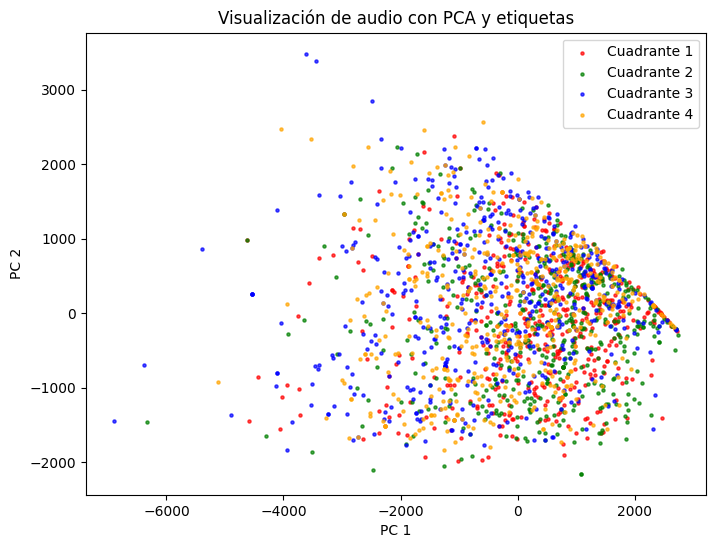

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
audio_array = pca.fit_transform(flattened_audio_features)

labels = df_merged_sampled["cuadReal"] 

plt.figure(figsize=(8, 6))

unique_labels = labels.unique()
colors = ["red", "green", "blue", "orange"]
label_to_color = dict(zip(unique_labels, colors))

for lbl in unique_labels:
    idx = labels == lbl
    plt.scatter(audio_array[idx, 0], audio_array[idx, 1],
                s=5, alpha=0.7,
                color=label_to_color[lbl],
                label=f"Cuadrante {lbl}")

plt.title("Visualización de audio con PCA y etiquetas")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()

In [ ]:
scaler_audio = StandardScaler()
scaled_audio_features = scaler_audio.fit_transform(flattened_audio_features)

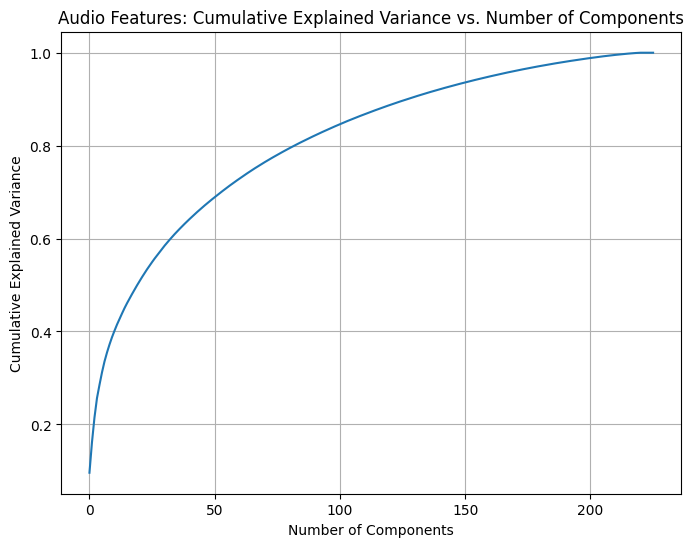

In [ ]:
pca_audio_full = PCA()
pca_audio_full.fit(scaled_audio_features)

explained_variance_ratio_audio = np.cumsum(pca_audio_full.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(explained_variance_ratio_audio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Audio Features: Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
pca_audio = PCA(n_components=175)
pca_audio_features = pca_audio.fit_transform(scaled_audio_features)
print(f"Number of audio components after PCA: {pca_audio.n_components_}")

Number of audio components after PCA: 175


In [ ]:
audio_features_array = pca_audio_features.reshape(num_songs, -1, pca_audio.n_components_) 

## Preparar características de texto

In [32]:
df_merged_sampled['Idioma'].unique()

array(['en', 'it', 'pt', 'es', 'fy', 'de', None, 'gl', 'fr', 'xh', 'ro',
       'sv', 'eo', 'ar', 'id', 'nl', 'no', 'eu', 'war', 'ca',
       'romanization', 'tr', 'lt', 'la', 'pl'], dtype=object)

In [38]:
import re
import pandas as pd

def clean_lyrics(lyrics_text):
    """
    Elimina las líneas que contienen texto entre corchetes, por ejemplo, [Chorus], [Intro], etc.
    """
    lyrics_str = str(lyrics_text)
    lines = lyrics_str.splitlines()
    cleaned_lines = []
    for line in lines:
        if re.search(r'\[.*?\]', line):
            continue
        cleaned_lines.append(line)

    return "\n".join(cleaned_lines)


df_merged_sampled['Lyrics_cleaned'] = df_merged_sampled['Lyrics'].apply(clean_lyrics)


In [39]:
df_merged_sampled['Lyrics']

985     Brighter Day Lyrics(Steen)\n\nCome on baby, I'...
3386    5 ContributorsIl Sole Esiste per Tutti Lyrics[...
2969    6 ContributorsHot Venom Lyrics[Verse 1]\nHer v...
1644    Dinah-Moe Humm LyricsI couldn't say where she'...
1987    SSJGOD Rap God parody Lyrics[Goku]\nI'm beginn...
                              ...                        
1055    9 ContributorsCalendar Girl Lyrics[Verse]\nIf ...
1541    Dead Lyrics[Verse 1]\nI returned a bag of groc...
3613    1 ContributorMacorina LyricsPonme la mano aquí...
4209    The Summoning Lyrics"We were in distress\nOur ...
1471    1 ContributorThe Dance LyricsWould you be inte...
Name: Lyrics, Length: 2060, dtype: object

In [40]:
df_merged_sampled['Lyrics_cleaned'].iloc[0]

"Brighter Day Lyrics(Steen)\n\nCome on baby, I'm in love with you\nI can't get it off my mind\nI've been thinking I've been dreamin'\n'Bout this heart of mine\n\nIn a day we'll know, oh we'll know, yes we'll know\n'Bout a heart that's strong\nAnd a mind that is wrong\nTake my hand and see\nAll the things you can be\nDoodn doo doo doo doodn doo doodn doo\nDoodn doo doo doo\nCome on baby I'm in love with you\nI can't get it off my mind\nMind's been foggy since I first spied that baby\nI can't get it off my mind\n\nFirst the sun will shine\nSee how bright the day\nThen the rains will come\nWash away, wash away\nAll the blues will go\nOh we'll know, yes we'll know\nDoodn doo doo doo doodn doo doodn doo\nDoodn doo doo doo\n\nBrighter day\nCome on babyYou might also likeEmbed"

In [33]:
import os
import joblib
import transformers
from sentence_transformers import SentenceTransformer

embedding_filename = "hf_embeddings_NewQ4.joblib"
model_name = "sentence-transformers/LaBSE"

if os.path.exists(embedding_filename):
    # Cargamos los embeddings pre-generados
    print(f"Loading precomputed embeddings from {embedding_filename}...")
    hf_embeddings = joblib.load(embedding_filename)
    print("Embeddings loaded.")
else:
    # Cargamos el modelo preentrenado de Sentence-BERT
    print(f"Loading the SentenceTransformer model: {model_name}...")
    model = SentenceTransformer(model_name)

    print("Generating embeddings for lyrics...")
    hf_embeddings = model.encode(
        df_merged_sampled["Lyrics_proces"].tolist(),
        batch_size=32,           # Ajusta según tu hardware
        show_progress_bar=True   
    )

    print("Embeddings generated. Saving to disk...")
    joblib.dump(hf_embeddings, embedding_filename)
    print(f"Embeddings saved as {embedding_filename}.")

print("Shape of hf_embeddings:", hf_embeddings.shape)


c:\Users\andre\anaconda3\envs\tf_gpu_4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Transformers is only compatible with Keras 2, but you have explicitly set `TF_USE_LEGACY_KERAS` to `0`. This may result in unexpected behaviour or errors if Keras 3 objects are passed to Transformers models.


Loading precomputed embeddings from hf_embeddings_NewQ4.joblib...
Embeddings loaded.
Shape of hf_embeddings: (4349, 768)


In [42]:
del df, df_audio_1,df_audio_2,df_audio_3,df_audio_4,df_audio_5,df_audio_6,df_audio_7,df_audio_features

## PCA para embbedings

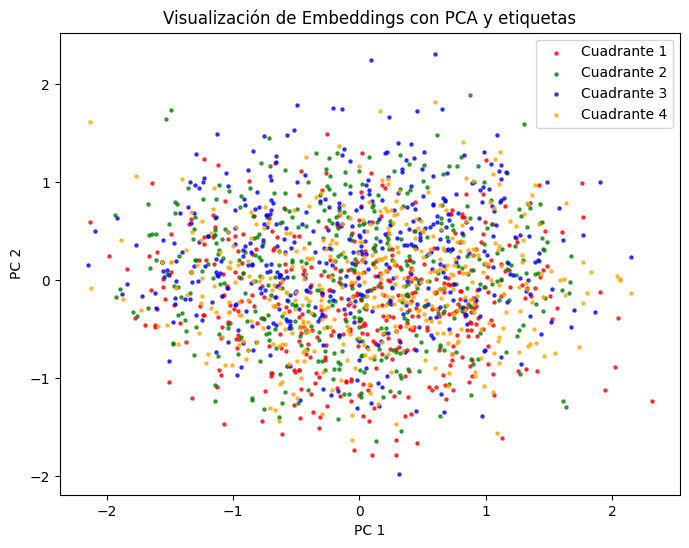

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(hf_embeddings)

labels = df_merged_sampled["cuadReal"] 

plt.figure(figsize=(8, 6))

¡
unique_labels = labels.unique()
colors = ["red", "green", "blue", "orange"]
label_to_color = dict(zip(unique_labels, colors))

for lbl in unique_labels:
    idx = labels == lbl
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1],
                s=5, alpha=0.7,
                color=label_to_color[lbl],
                label=f"Cuadrante {lbl}")

plt.title("Visualización de Embeddings con PCA y etiquetas")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()


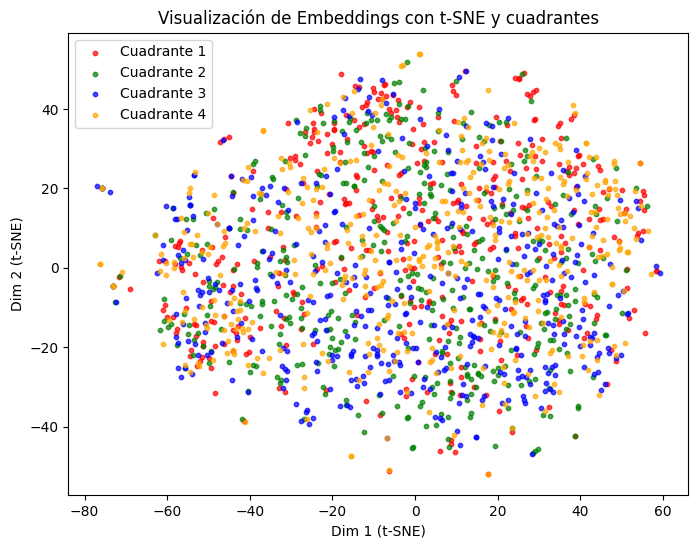

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Suponiendo que tus embeddings son hf_embeddings con forma (N, D)
# Y tus cuadrantes están en df_merged_sampled["cuadReal"]

# Extrae los cuadrantes como un array
labels = df_merged_sampled["cuadReal"].values

# Aplica t-SNE para reducir a 2 dimensiones
tsne = TSNE( perplexity=10, random_state=42)
embeddings_2d_tsne = tsne.fit_transform(hf_embeddings)

# Grafica los puntos, coloreados por cuadrante
plt.figure(figsize=(8, 6))

unique_labels = np.unique(labels)
colors = ["red", "green", "blue", "orange", "purple", "cyan"]  # Ajusta si hay más cuadrantes

# Asigna un color a cada cuadrante
label_to_color = {lbl: colors[i % len(colors)] for i, lbl in enumerate(unique_labels)}

for lbl in unique_labels:
    idx = labels == lbl
    plt.scatter(embeddings_2d_tsne[idx, 0], embeddings_2d_tsne[idx, 1],
                s=10, alpha=0.7,
                color=label_to_color[lbl],
                label=f"Cuadrante {lbl}")

plt.title("Visualización de Embeddings con t-SNE y cuadrantes")
plt.xlabel("Dim 1 (t-SNE)")
plt.ylabel("Dim 2 (t-SNE)")
plt.legend()
plt.show()


In [ ]:
scaler_text = StandardScaler(with_mean=False) #with_mean = False, since the data is sparse
tfidf_matrix_scaled = scaler_text.fit_transform(tfidf_matrix)

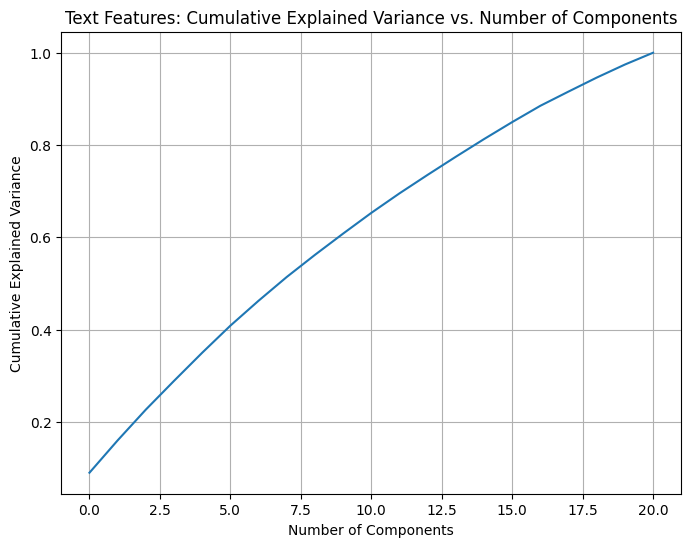

In [ ]:
pca_text_full = PCA()
pca_text_full.fit(tfidf_matrix_scaled.toarray())  

explained_variance_ratio_text = np.cumsum(pca_text_full.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(explained_variance_ratio_text)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Text Features: Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
pca_text = PCA(n_components=800)
pca_text_features = pca_text.fit_transform(tfidf_matrix_scaled.toarray())
print(f"Number of text components after PCA: {pca_text.n_components_}")

Number of text components after PCA: 800


In [ ]:
df.head(2)

,song_id,Idioma,lyrics_state,hasLetra,Lyrics,Lyrics_proces,track_uri,emocion_mas_comun,cuadrante,cuadReal
0,21 seconds - dj swiss dan da man remix vocal -...,en,complete,1.0,7 ContributorsAngela’s Ashes LyricsAngela's As...,angelas ashes memoir childhood frank mccourt b...,spotify:track:0N9LQXtUL7TLtIoa7gpJfX,3,0,1
1,240 - samad savage,en,complete,1.0,18 ContributorsI Knew I Loved You Lyrics[Intro...,cool cruel sleaze hungry wild crawling storm b...,spotify:track:0GYXt2CnvXNXA1Bv6n493A,3,0,1


In [ ]:
df_audio_features.head(2)

,song_id,beat_features
0,240 - samad savage,"[[0.1179114505648613, 0.11783639341592789, 0.2..."
1,21 seconds - dj swiss dan da man remix vocal -...,"[[0.6232354044914246, 0.7310153841972351, 0.68..."


In [ ]:
df_merged.head(2)

,Idioma,lyrics_state,hasLetra,Lyrics,Lyrics_proces,song_id,track_uri,emocion_mas_comun,cuadrante,cuadReal,beat_features
0,en,complete,1.0,7 ContributorsAngela’s Ashes LyricsAngela's As...,angelas ashes memoir childhood frank mccourt b...,21 seconds - dj swiss dan da man remix vocal -...,spotify:track:0N9LQXtUL7TLtIoa7gpJfX,3,0,1,"[[0.6232354044914246, 0.7310153841972351, 0.68..."
1,en,complete,1.0,18 ContributorsI Knew I Loved You Lyrics[Intro...,cool cruel sleaze hungry wild crawling storm b...,240 - samad savage,spotify:track:0GYXt2CnvXNXA1Bv6n493A,3,0,1,"[[0.1179114505648613, 0.11783639341592789, 0.2..."


In [ ]:
scaled_audio_features.shape

(226, 14934)

## Metadatos

In [36]:
# Ejemplo X_meta con sólo las 6 columnas que quieres:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# One‑hot emoción más común
X_emc = pd.get_dummies(df_merged_sampled['emocion_mas_comun'].astype(int), prefix='emc').values

# Numéricas
num_cols = ['acousticness','loudness','danceability']
X_num = df_merged_sampled[num_cols].values
X_num = StandardScaler().fit_transform(X_num)

# Concatena
X_meta = np.concatenate([X_num,X_emc], axis=1)  # shape (N, emc_classes + 5)


## Train y test

In [37]:
X_audio = audio_features_array
X_text = hf_embeddings

y = df_merged_sampled['cuadReal'].values.astype(int)
y = tf.keras.utils.to_categorical(y, num_classes=5) 
y = y[:, 1:] 

In [38]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(X_audio))
# 1) Primero separa el 15% para TEST
Xa_rest, Xa_test, Xt_rest, Xt_test, Xm_rest, Xm_test, y_rest, y_test, idx_train, idx_test = train_test_split(
    X_audio, X_text, X_meta,y,indices,
    test_size=0.15,
    stratify=y,
    random_state=42
)

val_size = 0.15 / 0.85  # ≈ 0.17647

Xa_train, Xa_val, Xt_train, Xt_val, Xm_train, Xm_val, y_train, y_val = train_test_split(
    Xa_rest, Xt_rest, Xm_rest, y_rest,
    test_size=val_size,
    stratify=y_rest,
    random_state=42
)

# Comprueba proporciones
print("Train:", Xa_train.shape[0], 
      "Val:",   Xa_val.shape[0], 
      "Test:",  Xa_test.shape[0])


Train: 3043 Val: 653 Test: 653


## Modelo multimodal : Audio + texto + matadatos

In [68]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    Conv1D, MaxPooling1D, Bidirectional, LSTM,
    Concatenate, Layer
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class FusionGate(Layer):
    """Fusion layer that learns a gating vector to weight modalities."""
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.sigmoid_dense = Dense(units, activation="sigmoid")
    def call(self, inputs):
        # inputs is a list: [audio_repr, text_repr, meta_repr]
        merged = tf.concat(inputs, axis=-1)
        gate = self.sigmoid_dense(merged)
        return merged * gate

In [69]:
def create_multimodal_model_v2(
    max_len_frames: int,
    num_audio_features: int,
    text_dim: int,
    meta_dim: int,
    num_classes: int = 4,
    lr: float = 1e-4
) -> tf.keras.Model:
    # — Inputs —
    aud_in  = Input(shape=(max_len_frames, num_audio_features), name='audio_input')
    txt_in  = Input(shape=(text_dim,), name='text_input')
    meta_in = Input(shape=(meta_dim,), name='meta_input')

    # — Audio branch: 2×Conv1D + MaxPool → Bi-LSTM → Dropout —
    x = Conv1D(128, 3, padding='same', activation='relu', name='aud_conv1')(aud_in)
    x = BatchNormalization(name='aud_bn1')(x)
    x = MaxPooling1D(2, name='aud_pool1')(x)

    x = Conv1D(256, 3, padding='same', activation='relu', name='aud_conv2')(x)
    x = BatchNormalization(name='aud_bn2')(x)
    x = MaxPooling1D(2, name='aud_pool2')(x)

    x = Bidirectional(LSTM(32, return_sequences=False), name='aud_bilstm')(x)
    x = Dropout(0.3, name='aud_dropout')(x)

    # — Text branch: Dense(256) → BN → Dropout → Dense(128) → Dropout —
    t = Dense(256, activation='relu', name='txt_dense1')(txt_in)
    t = BatchNormalization(name='txt_bn1')(t)
    t = Dropout(0.3, name='txt_dropout1')(t)
    t = Dense(128, activation='relu', name='txt_dense2')(t)
    t = BatchNormalization(name='txt_bn2')(t)
    t = Dropout(0.3, name='txt_dropout2')(t)

    # — Meta branch: Dense(128) → BN → Dropout → Dense(64) → Dropout —
    m = Dense(128, activation='relu', name='meta_dense1')(meta_in)
    m = BatchNormalization(name='meta_bn1')(m)
    m = Dropout(0.3, name='meta_dropout1')(m)
    m = Dense(64, activation='relu', name='meta_dense2')(m)
    m = BatchNormalization(name='meta_bn2')(m)
    m = Dropout(0.3, name='meta_dropout2')(m)

    # — Gated fusion of [x, t, m] —
    total_units = x.shape[-1] + t.shape[-1] + m.shape[-1]  # 64 + 128 + 64 = 256
    gated = FusionGate(units=total_units, name='fusion_gate')([x, t, m])

    # — Classification head: Dense(512) → BN → Dropout → Dense(256) → BN → Dropout → Softmax —
    y = Dense(512, activation='relu', name='clf_dense1')(gated)
    y = BatchNormalization(name='clf_bn1')(y)
    y = Dropout(0.3, name='clf_dropout1')(y)

    y = Dense(256, activation='relu', name='clf_dense2')(y)
    y = BatchNormalization(name='clf_bn2')(y)
    y = Dropout(0.2, name='clf_dropout2')(y)

    out = Dense(num_classes, activation='softmax', name='cuad_output')(y)

    model = Model([aud_in, txt_in, meta_in], out, name='Multimodal_Cuad_v2')
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [70]:
model = create_multimodal_model_v2(
    max_len_frames=449,
    num_audio_features=38,
    text_dim=768,
    meta_dim=X_meta.shape[1],
    num_classes=4
)
model.summary()

Model: "Multimodal_Cuad_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 audio_input (InputLayer)       [(None, 449, 38)]    0           []                               
                                                                                                  
 aud_conv1 (Conv1D)             (None, 449, 128)     14720       ['audio_input[0][0]']            
                                                                                                  
 aud_bn1 (BatchNormalization)   (None, 449, 128)     512         ['aud_conv1[0][0]']              
                                                                                                  
 text_input (InputLayer)        [(None, 768)]        0           []                               
                                                                                 

In [73]:
from sklearn.model_selection import train_test_split

history = model.fit(
    x = {
      'audio_input': Xa_train,
      'text_input' : Xt_train,
      'meta_input' : Xm_train
    },
    y = y_train,
    validation_data = (
      {
        'audio_input': Xa_val,
        'text_input' : Xt_val,
        'meta_input' : Xm_val
      },
      y_val
    ),
    epochs=100,
    batch_size=16,
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
    ]
)


Epoch 1/100
191/191 [==============================] - 18s 48ms/step - loss: 1.6521 - accuracy: 0.3710 - val_loss: 1.4165 - val_accuracy: 0.2542 - lr: 1.0000e-04
Epoch 2/100
191/191 [==============================] - 8s 40ms/step - loss: 1.3051 - accuracy: 0.4854 - val_loss: 1.0656 - val_accuracy: 0.4946 - lr: 1.0000e-04
Epoch 3/100
191/191 [==============================] - 8s 40ms/step - loss: 1.2567 - accuracy: 0.5212 - val_loss: 0.9075 - val_accuracy: 0.6003 - lr: 1.0000e-04
Epoch 4/100
191/191 [==============================] - 9s 46ms/step - loss: 1.1807 - accuracy: 0.5439 - val_loss: 0.8834 - val_accuracy: 0.6248 - lr: 1.0000e-04
Epoch 5/100
191/191 [==============================] - 7s 39ms/step - loss: 1.1372 - accuracy: 0.5583 - val_loss: 0.8739 - val_accuracy: 0.6187 - lr: 1.0000e-04
Epoch 6/100
191/191 [==============================] - 8s 39ms/step - loss: 1.1097 - accuracy: 0.5649 - val_loss: 0.8592 - val_accuracy: 0.6447 - lr: 1.0000e-04
Epoch 7/100
191/191 [============

In [85]:
model = tf.keras.models.load_model('modeloBestAllQ-68/')

In [86]:
#model.summary()

In [87]:
loss, accuracy = model.evaluate({'audio_input': Xa_test, 'text_input': Xt_test, 'meta_input': Xm_test}, y_test, verbose=0)
print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")

Final Test Loss: 0.7517
Final Test Accuracy: 0.6907


In [88]:
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

Final Validation Loss: 0.8084
Final Validation Accuracy: 0.6539


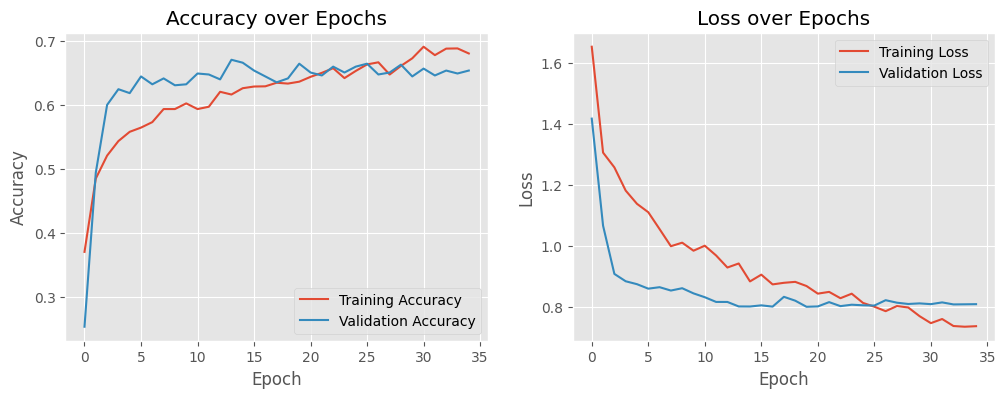

In [89]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


## Metricas de Validación

In [90]:
predictions = model.predict({'audio_input': Xa_test, 'text_input': Xt_test, 'meta_input': Xm_test})
predicted_classes = np.argmax(predictions, axis=1) + 1  
y_test_labels = np.argmax(y_test, axis=1) + 1

21/21 [==============================] - 1s 10ms/step


Umbrales óptimos por clase: {0: 0.41000000000000003, 1: 0.28, 2: 0.35000000000000003, 3: 0.44}
=== Matriz tras thresholding ===


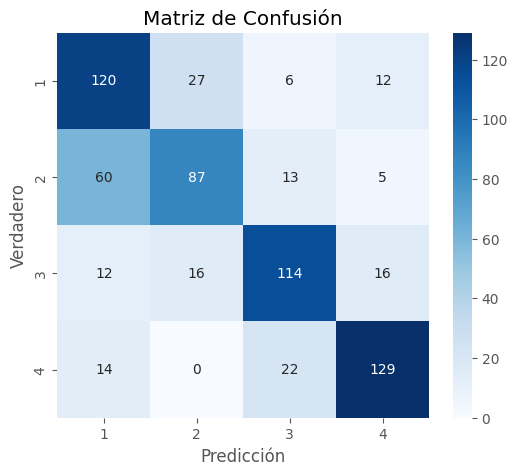

              precision    recall  f1-score   support

          C1       0.58      0.73      0.65       165
          C2       0.67      0.53      0.59       165
          C3       0.74      0.72      0.73       158
          C4       0.80      0.78      0.79       165

    accuracy                           0.69       653
   macro avg       0.70      0.69      0.69       653
weighted avg       0.70      0.69      0.69       653



In [91]:
import numpy as np
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize

y_val_bin = label_binarize(y_test_labels, classes=[1,2,3,4])

# 2.3 Busca el umbral que maximice F1 para cada clase
best_thresh = {}
for i in range(4):
    best_f1, best_t = 0, 0.5
    for t in np.linspace(0,1,101):
        y_pred_i = (predictions[:,i] >= t).astype(int)
        f1 = f1_score(y_val_bin[:,i], y_pred_i)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    best_thresh[i] = best_t
print("Umbrales óptimos por clase:", best_thresh)

# 2.4 Predecir en test aplicando esos umbrales
y_test_score = predictions  # shape (n_test,4)
n_test = y_test_score.shape[0]

y_thresh_bin = np.zeros_like(y_test_score, dtype=int)
for i in range(4):
    y_thresh_bin[:,i] = (y_test_score[:,i] >= best_thresh[i]).astype(int)

# 2.5 Convertir ese binarizado en etiqueta final:
# si un sample cruza varios umbrales, elige el que tenga mayor score; 
# si ninguno lo cruza, recae en el argmax original.

y_pred_thresh = []
for j in range(n_test):
    hits = np.where(y_thresh_bin[j]==1)[0]
    if len(hits)==1:
        y_pred_thresh.append(hits[0]+1)
    elif len(hits)>1:
        # de los que pasaron umbral, elige el que mayor probabilidad tenga
        best = hits[np.argmax(y_test_score[j,hits])]
        y_pred_thresh.append(best+1)
    else:
        # ninguno pasó el umbral → fallback a argmax
        y_pred_thresh.append(np.argmax(y_test_score[j])+1)

y_pred_thresh = np.array(y_pred_thresh)

cm2 = confusion_matrix(y_test_labels, y_pred_thresh, labels=[1,2,3,4])

print("=== Matriz tras thresholding ===")
plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(
    y_test_labels, y_pred_thresh,
    labels=[1,2,3,4],
    target_names=["C1","C2","C3","C4"]
))


In [92]:
# 3. Crear el DataFrame de visualización
plot_df = pd.DataFrame({
    'songId': df_merged_sampled.iloc[idx_test]['song_id'].values, 
    'predicted_quadrant': predicted_classes,
    'true_quadrant': y_test_labels,
    'cuadReal': df_merged_sampled.iloc[idx_test]['cuadReal'].values,
    'cuadrante': df_merged_sampled.iloc[idx_test]['cuadrante'].values,
    'emocion_mas_comun': df_merged_sampled.iloc[idx_test]['emocion_mas_comun'].values
})

plot_df = plot_df.dropna()
plot_df[['predicted_quadrant', 'true_quadrant']] = plot_df[['predicted_quadrant', 'true_quadrant']].astype(int)
plot_df['prediction_correct'] = plot_df['predicted_quadrant'] == plot_df['true_quadrant']

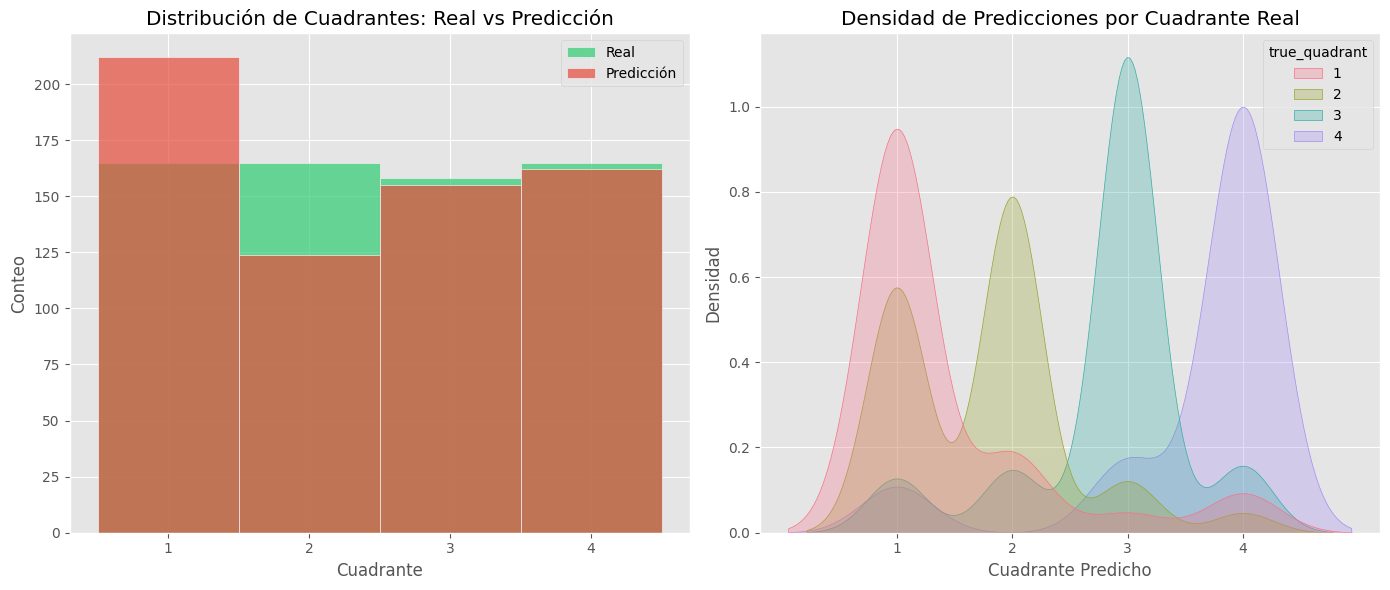

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
palette = sns.color_palette("husl", 4)

# 1. Histograma comparativo de distribución de cuadrantes
plt.figure(figsize=(14, 6))

# Gráfico para predicciones vs realidad
plt.subplot(1, 2, 1)
sns.histplot(data=plot_df, x='true_quadrant', bins=4, discrete=True,
             color='#2ecc71', alpha=0.7, label='Real', kde=False)
sns.histplot(data=plot_df, x='predicted_quadrant', bins=4, discrete=True,
             color='#e74c3c', alpha=0.7, label='Predicción', kde=False)
plt.title('Distribución de Cuadrantes: Real vs Predicción')
plt.xlabel('Cuadrante')
plt.ylabel('Conteo')
plt.xticks([1, 2, 3, 4])
plt.legend()

# 2. Matriz de densidad por cuadrante
plt.subplot(1, 2, 2)
sns.kdeplot(data=plot_df, x='predicted_quadrant', hue='true_quadrant',
            palette=palette, common_norm=False, fill=True, alpha=0.3)
plt.title('Densidad de Predicciones por Cuadrante Real')
plt.xlabel('Cuadrante Predicho')
plt.ylabel('Densidad')
plt.xticks([1, 2, 3, 4])

plt.tight_layout()
plt.show()



C:\Users\andre\AppData\Local\Temp\ipykernel_14892\1285869737.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=match_percentages.values, palette=colors)


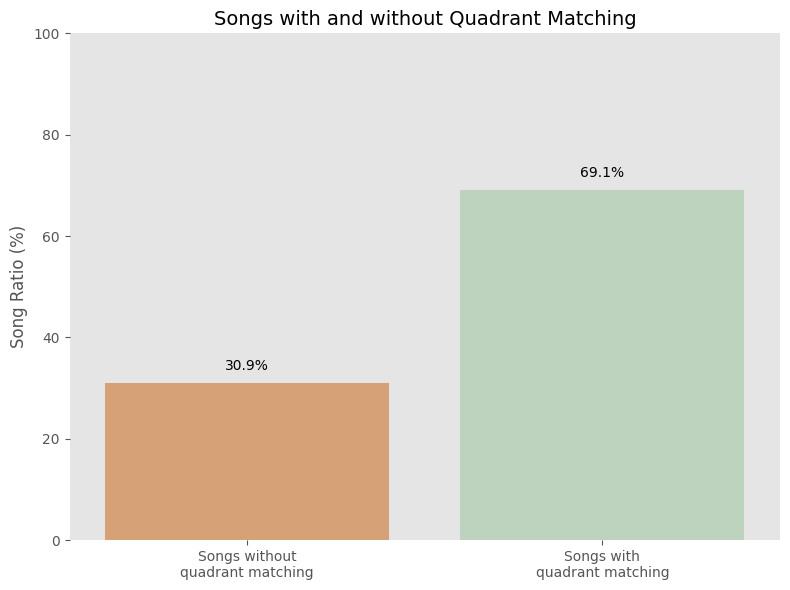

quadrant_match
False    30.9
True     69.1
Name: count, dtype: float64


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Calcula match_percentages como antes
plot_df['quadrant_match'] = plot_df['predicted_quadrant'] == plot_df['cuadReal']
match_counts = plot_df['quadrant_match'].value_counts()
match_percentages = (match_counts / len(plot_df) * 100).round(1)

# 2) Reindexa en el orden deseado: primero False, luego True
match_percentages = match_percentages.reindex([False, True])

# 3) Define las etiquetas en ese mismo orden
labels = ['Songs without\nquadrant matching', 'Songs with\nquadrant matching']
colors = ['#E69F66', '#B9D7B9']

# 4) Dibuja el barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=labels, y=match_percentages.values, palette=colors)

# 5) Ajusta título y ejes
plt.title('Songs with and without Quadrant Matching', fontsize=14)
plt.ylabel('Song Ratio (%)', fontsize=12)
plt.ylim(0, 100)

# 6) Anota los valores encima de cada barra
for i, v in enumerate(match_percentages.values):
    ax.text(i, v + 2, f"{v}%", ha='center', va='bottom', fontsize=10)

# 7) Limpia el estilo
sns.despine(left=True, bottom=True)
plt.grid(False)
plt.tight_layout()
plt.show()

# 8) Imprime las porcentajes para verificar
print(match_percentages)


In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes = [1, 2, 3, 4]
y_true_bin = label_binarize(y_test_labels, classes=classes)  # shape (n_samples, 4)
y_score    = predictions 

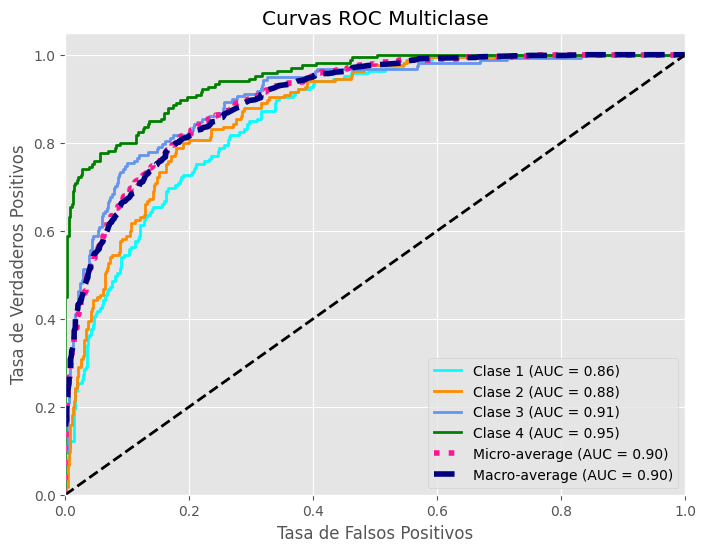

In [96]:
# --- 3. Calcula FPR, TPR y AUC para cada clase ---
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, c in enumerate(classes):
    fpr[i], tpr[i], _   = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i]          = auc(fpr[i], tpr[i])

# --- 4. Micro-average y Macro-average ---
# Micro-average (trata todas las muestras juntas)
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_bin.ravel(),
    y_score.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average (promedia las curvas de cada clase)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- 5. Dibuja las curvas ROC ---
plt.figure(figsize=(8, 6))

# Curvas por clase
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(len(classes)), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f'Clase {classes[i]} (AUC = {roc_auc[i]:0.2f})'
    )

# Curvas micro y macro
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f'Micro-average (AUC = {roc_auc["micro"]:0.2f})',
    color='deeppink', linestyle=':', linewidth=4
)
plt.plot(
    fpr["macro"], tpr["macro"],
    label=f'Macro-average (AUC = {roc_auc["macro"]:0.2f})',
    color='navy', linestyle='--', linewidth=4
)

# Línea de referencia aleatoria
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Ajustes de estilo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC Multiclase')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [97]:
#model.save("modeloBestAllQV2")